# _Trial 30_

__July 19, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
from capstone import sample

train_df, valid_df = sample.prep_data(path);

Read in training and validation data sets
------------------------------
Added column to both data sets that indicates if observation is part of validation set or not.
------------------------------
Extracted patient ID and study number for each observation and assigned into new columns.
------------------------------
Filled in NaNs within pathology columns with 0 (see Stanford ML Github for further information on dealing with NaNs).
------------------------------
Converted pathology columns to integer type.
------------------------------
Pre-replacement Label Distribution: Label 0 = 188327, Label 1 = 27000, Label -1 = 8087
------------------------------
Replaced uncertain labels in Cardiomegaly column with 0 (i.e. negative)
Post-replacement Label Distribution: Label 0 = 196414, Label 1 = 27000
Does number of post-replacement 0 labels equal the sum of pre-replacement -1s and 0s? True
Returned training and validation data sets as pandas dataframes.


In [6]:
# set seed to help with reproducibility
sample.set_seed(58)

In [7]:
full_df = sample.oversample_and_prep(train_df, valid_df, 0.3);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random over-sampling: 
1    196414
0    196414
Name: Cardiomegaly, dtype: int64
------------------------------
Sampled from over-sampled dataframe.
Value Counts for Cardiomegaly column in new dataframe: 
0    59075
1    58773
Name: Cardiomegaly, dtype: int64
------------------------------
Concatenated oversampled training data set with validation data.
Returning full data set.


In [8]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient09559/study1/...,Female,27,Lateral,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,False,patient09559,study1
1,CheXpert-v1.0-small/train/patient28371/study11...,Male,32,Frontal,PA,0,0,0,0,0,0,1,0,0,0,0,1,0,0,False,patient28371,study11
2,CheXpert-v1.0-small/train/patient28414/study1/...,Male,51,Lateral,NaN,0,0,1,1,0,1,0,0,0,0,1,0,0,0,False,patient28414,study1
3,CheXpert-v1.0-small/train/patient13227/study17...,Male,67,Frontal,AP,0,0,1,0,0,0,0,0,0,0,1,0,0,1,False,patient13227,study17
4,CheXpert-v1.0-small/train/patient13487/study2/...,Male,86,Frontal,PA,0,0,0,1,-1,0,0,0,0,1,1,0,0,-1,False,patient13487,study2


# _Deep Learning Fast.ai Set Up_

In [9]:
from capstone import replicate

src = replicate.get_src(full_df, path, feature_col='Cardiomegaly')

In [10]:
data = replicate.get_data(320, src, default_trans = False)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


In [11]:
data

ImageDataBunch;

Train: LabelList (117848 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,1,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Create DenseNet Model_

__First Round of Training__

In [12]:
learn = cnn_learner(data=data, base_arch=models.densenet121, 
                    metrics=[AUROC(), Recall(), Precision(), error_rate],
                    pretrained=True, ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.24E-06
Min loss divided by 10: 8.51E-02


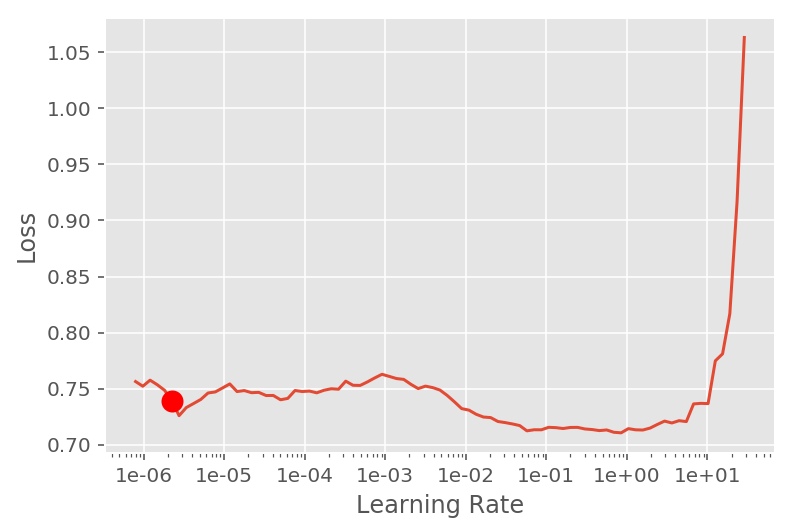

In [13]:
from capstone import deeplearning

deeplearning.lr_finder_plot(learn);

In [14]:
learn.fit_one_cycle(5, 9e-3, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best-dn121-trial30-rd1')])


epoch,train_loss,valid_loss,auroc,recall,precision,error_rate,time
0,0.506237,0.421783,0.864103,0.647059,0.676923,0.192308,43:22
1,0.521744,0.473742,0.815291,0.367647,0.657895,0.239316,42:31
2,0.499431,0.435838,0.842576,0.529412,0.782609,0.179487,42:26
3,0.471259,0.460393,0.813076,0.514706,0.729167,0.196581,42:26
4,0.469090,0.447554,0.826541,0.397059,0.729730,0.217949,42:27


Better model found at epoch 0 with auroc value: 0.8641034960746765.


In [15]:
learn.save('trial30-rd1')

# Second Round of Training

In [17]:
learn.load('trial30-rd1');

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.94E-08


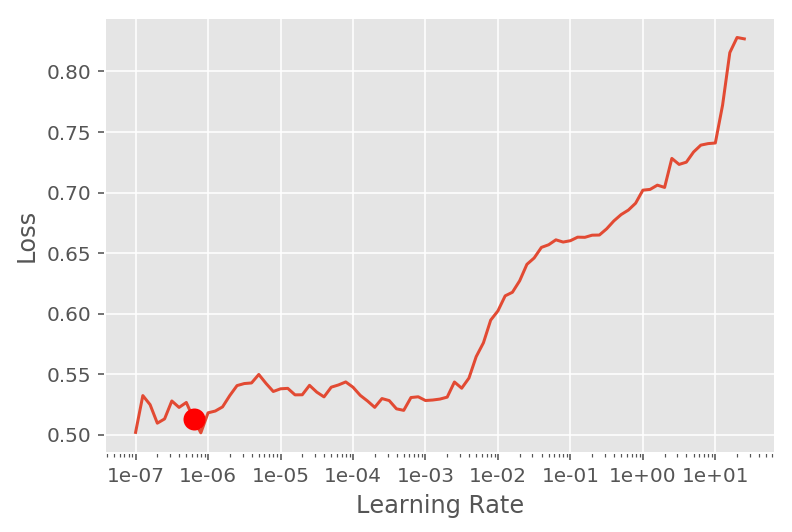

In [19]:
from capstone import deeplearning
deeplearning.lr_finder_plot(learn);

In [20]:
lr = learn.recorder.min_grad_lr
lr

6.309573444801932e-07

In [ ]:
learn.fit_one_cycle(5, slice(lr, lr/5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best-dn121-trial30-rd2')])


epoch,train_loss,valid_loss,auroc,recall,precision,error_rate,time
0,0.502819,0.453218,0.824593,0.441176,0.652174,0.230769,57:26
1,0.482595,0.458340,0.819189,0.500000,0.641509,0.226496,57:36


Better model found at epoch 0 with auroc value: 0.8245925307273865.


# _Third Round w/ new data_

In [17]:
# set seed to help with reproducibility
sample.set_seed(85)

In [18]:
full_df_2 = sample.oversample_and_prep(train_df, valid_df, 0.1);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random over-sampling: 
1    196414
0    196414
Name: Cardiomegaly, dtype: int64
------------------------------
Sampled from over-sampled dataframe.
Value Counts for Cardiomegaly column in new dataframe: 
0    19720
1    19563
Name: Cardiomegaly, dtype: int64
------------------------------
Concatenated oversampled training data set with validation data.
Returning full data set.


In [19]:
full_df_2.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient41183/study1/...,Male,48,Frontal,AP,0,0,1,0,0,1,1,-1,0,0,1,0,0,1,False,patient41183,study1
1,CheXpert-v1.0-small/train/patient50337/study1/...,Female,79,Frontal,AP,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,patient50337,study1
2,CheXpert-v1.0-small/train/patient34101/study3/...,Male,80,Frontal,AP,0,1,1,1,0,1,0,0,0,0,0,0,0,1,False,patient34101,study3
3,CheXpert-v1.0-small/train/patient16719/study13...,Male,58,Lateral,NaN,0,0,1,1,0,1,0,0,0,0,1,0,0,1,False,patient16719,study13
4,CheXpert-v1.0-small/train/patient30643/study1/...,Female,60,Frontal,AP,0,0,0,0,0,0,0,1,1,0,0,0,0,1,False,patient30643,study1


In [20]:
src_2 = replicate.get_src(full_df_2, path, feature_col='Cardiomegaly')

In [21]:
data_2 = replicate.get_data(320, src_2, default_trans = False)

using bs=16, have 7002MB of GPU RAM free.
------------------------------
Data ready.


In [22]:
data_2

ImageDataBunch;

Train: LabelList (39283 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,1,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [23]:
learn.data = data_2

In [24]:
learn.load('best-dn121-trial30-rd2');

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-07
Min loss divided by 10: 6.31E-07


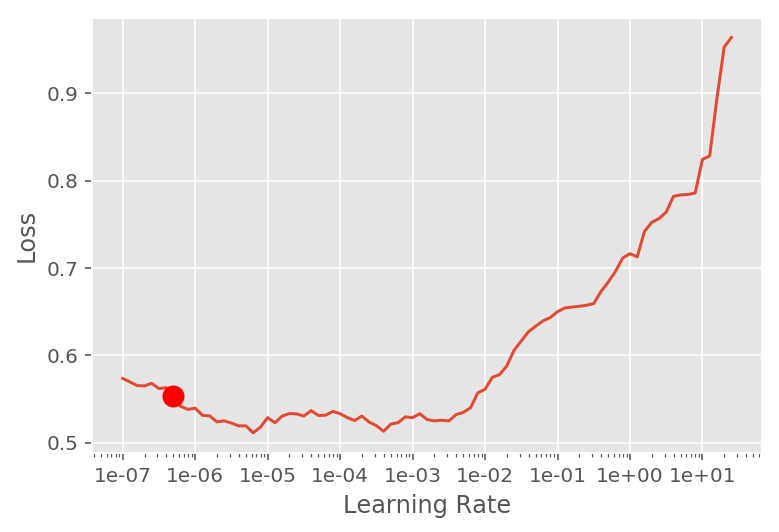

In [26]:
from capstone import deeplearning
deeplearning.lr_finder_plot(learn);

In [27]:
lr = learn.recorder.min_grad_lr
lr

5.011872336272725e-07

In [28]:
learn.fit_one_cycle(5, slice(lr, lr/5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best-dn121-trial30-rd3')])

epoch,train_loss,valid_loss,auroc,recall,precision,error_rate,time
0,0.515906,0.456392,0.826099,0.529412,0.642857,0.222222,19:52
1,0.506160,0.456472,0.822378,0.544118,0.637931,0.222222,19:27
2,0.511294,0.461590,0.824504,0.573529,0.639344,0.217949,19:28
3,0.509234,0.457913,0.820517,0.529412,0.654545,0.217949,19:28
4,0.500605,0.461672,0.814670,0.485294,0.660000,0.222222,19:27


Better model found at epoch 0 with auroc value: 0.8260985612869263.


# _Fourth Round with new data_

In [30]:
# set seed to help with reproducibility
sample.set_seed(22)

In [31]:
full_df_3 = sample.oversample_and_prep(train_df, valid_df, 0.1);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random over-sampling: 
1    196414
0    196414
Name: Cardiomegaly, dtype: int64
------------------------------
Sampled from over-sampled dataframe.
Value Counts for Cardiomegaly column in new dataframe: 
0    19786
1    19497
Name: Cardiomegaly, dtype: int64
------------------------------
Concatenated oversampled training data set with validation data.
Returning full data set.


In [32]:
full_df_3.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient14886/study6/...,Male,23,Frontal,AP,0,0,0,0,0,1,0,0,0,0,1,0,0,0,False,patient14886,study6
1,CheXpert-v1.0-small/train/patient04024/study3/...,Male,64,Frontal,AP,0,1,0,1,0,0,-1,0,-1,0,1,0,0,1,False,patient04024,study3
2,CheXpert-v1.0-small/train/patient28913/study7/...,Female,90,Frontal,AP,0,0,0,0,0,1,1,0,0,0,1,0,0,0,False,patient28913,study7
3,CheXpert-v1.0-small/train/patient05979/study1/...,Male,41,Lateral,NaN,0,1,1,0,1,0,0,-1,0,0,0,0,0,0,False,patient05979,study1
4,CheXpert-v1.0-small/train/patient26848/study16...,Female,60,Frontal,AP,0,0,0,1,0,1,0,0,0,0,0,0,0,1,False,patient26848,study16


In [33]:
src_3 = replicate.get_src(full_df_3, path, feature_col='Cardiomegaly')

In [34]:
data_3 = replicate.get_data(320, src_3, default_trans = False)

using bs=16, have 6902MB of GPU RAM free.
------------------------------
Data ready.


In [35]:
data_3

ImageDataBunch;

Train: LabelList (39283 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [36]:
learn.data = data_3

In [37]:
learn.load('best-dn121-trial30-rd3');

In [38]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.26E-07
Min loss divided by 10: 2.51E-07


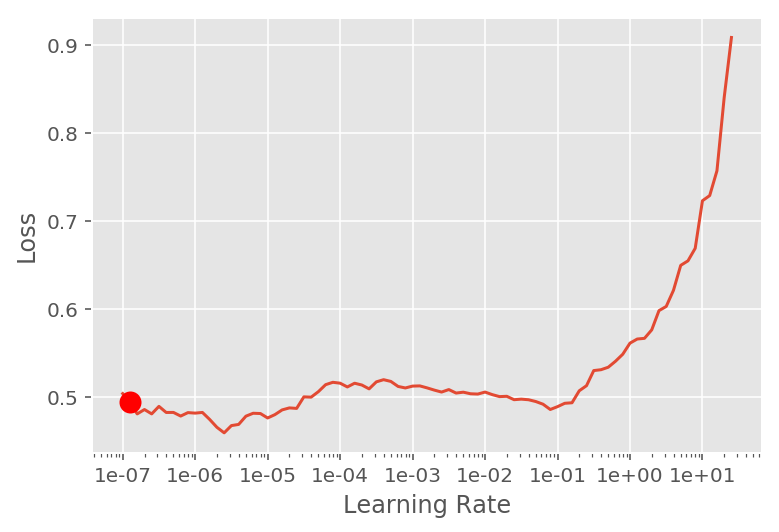

In [39]:
deeplearning.lr_finder_plot(learn);

In [41]:
lr = 3e-6
lr

3e-06

In [42]:
learn.fit_one_cycle(3, slice(lr, lr/5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best-dn121-trial30-rd4')])

epoch,train_loss,valid_loss,auroc,recall,precision,error_rate,time
0,0.482031,0.460714,0.821846,0.544118,0.637931,0.222222,14:24
1,0.499229,0.455657,0.825478,0.529412,0.679245,0.209402,14:19
2,0.498444,0.454231,0.828490,0.558824,0.644068,0.217949,14:19


Better model found at epoch 0 with auroc value: 0.8218462467193604.
Better model found at epoch 1 with auroc value: 0.8254783749580383.
Better model found at epoch 2 with auroc value: 0.8284904360771179.


# _Interpret the results_

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

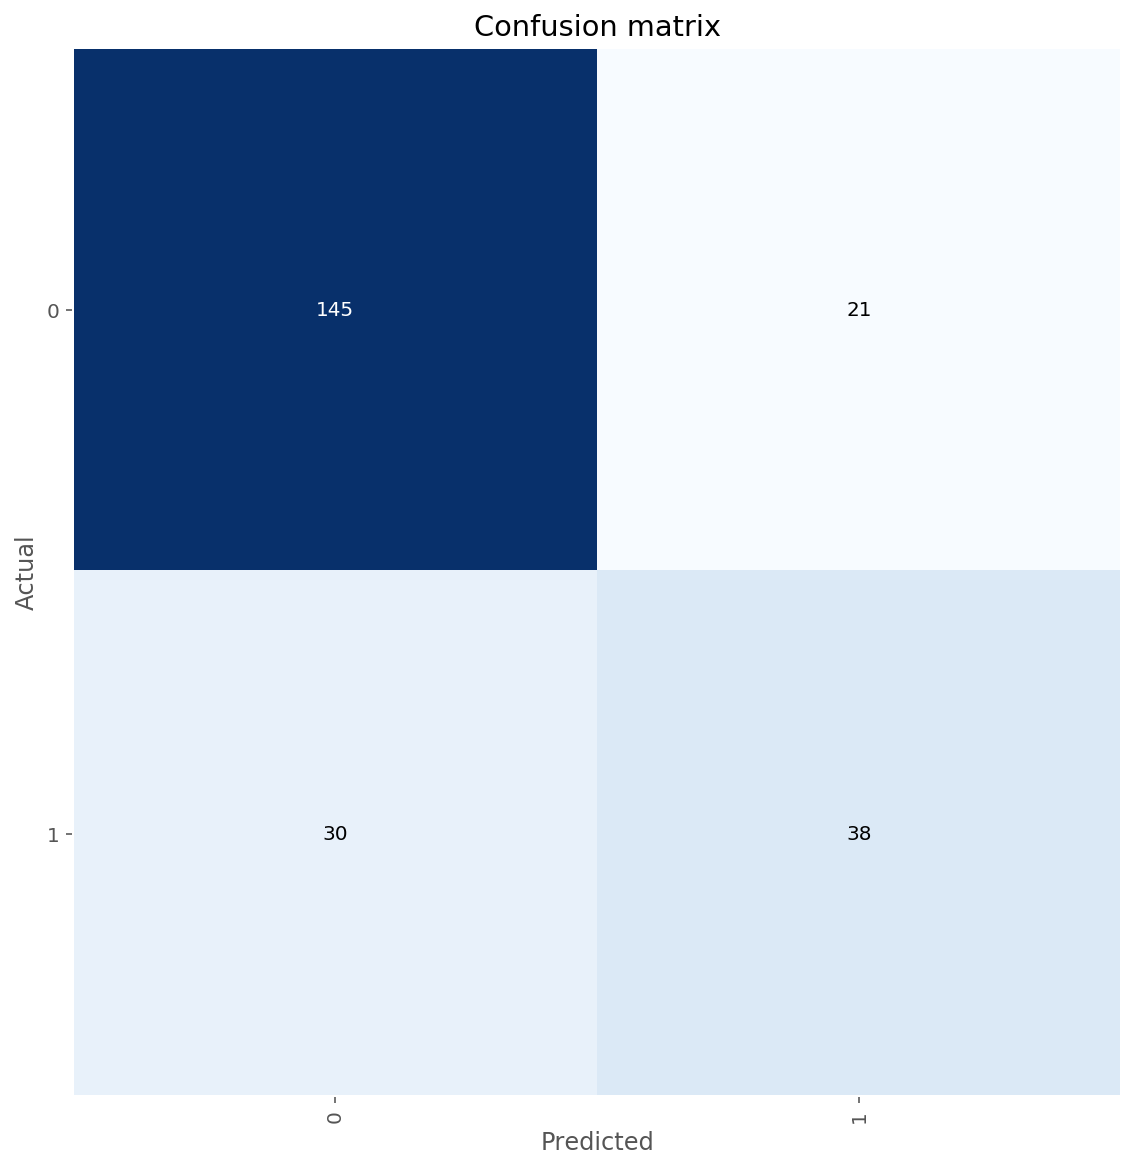

In [44]:
interp.plot_confusion_matrix(figsize=(8,8))

In [45]:
interp.most_confused()

[(1, 0, 30), (0, 1, 21)]

# _Fifth Round of Training_

In [46]:
learn.load('best-dn121-trial30-rd4');

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-07
Min loss divided by 10: 2.00E-07


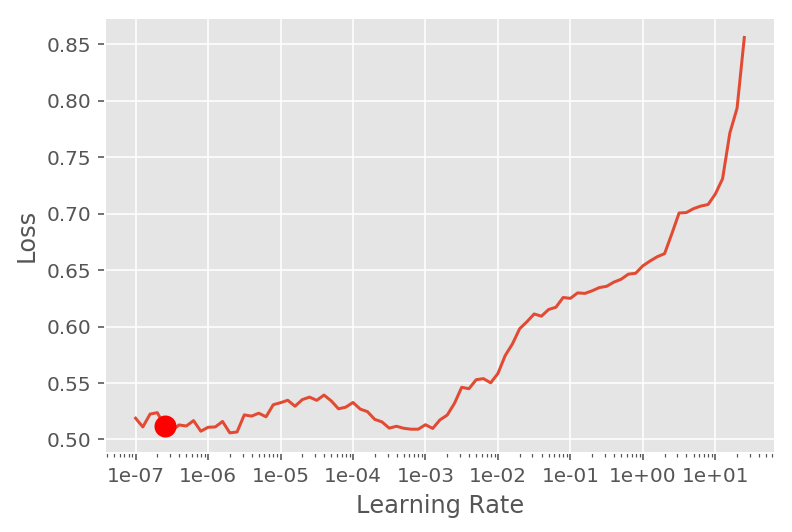

In [48]:
deeplearning.lr_finder_plot(learn);

In [49]:
lr = learn.recorder.min_grad_lr
lr

2.511886431509581e-07

In [50]:
learn.fit_one_cycle(3, slice(lr, 3e-4), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best-dn121-trial30-rd5')])

epoch,train_loss,valid_loss,auroc,recall,precision,error_rate,time
0,0.515831,0.468307,0.819454,0.485294,0.600000,0.243590,19:29
1,0.493614,0.457376,0.827693,0.470588,0.695652,0.213675,19:30
2,0.482237,0.451895,0.832920,0.441176,0.681818,0.222222,19:31


Better model found at epoch 0 with auroc value: 0.8194541931152344.
Better model found at epoch 1 with auroc value: 0.8276931047439575.
Better model found at epoch 2 with auroc value: 0.8329199552536011.
